In [ ]:
%pylab inline

This notebook contains code to reproduce the following from Mitra, et al.:

**Main Figures:** 
* Figure 3A: Number of mutations by category in siblings/probands
* Figure 3B: Odds ratio by category
* Figure 3C: Mutation size by category
* Figure 4A: Odds ratio by AF bin
* Figure 4B: Odds ratio by AF bin/locus selection
* Figure 4C: Odds ratio by AF bin/allele selection

**Extended Data Figures:** 
* Extended Data Figure 4a: Odds ratio by category, excluding homopolymers
* Extended Data Figure 4b: Odds ratio by AF, excluding homopolymers
* Extended Data Figure 7: Overlap with GWAS
* Extended Data Figure 9: AF of de novo alleles

**Supplementary Tables:** 
* Supplementary Table 5: excess by phase
* Supplementary Table 6: coding mutations (auto+X)
* Supplementary Table 7: deleterious mutations
* Supplementary Table 8: expansions (auto+X)

**Statistics:**
* Mean num proband autosomal mutations
* Mean num sibling autosomal mutations
* Excess in probands vs. siblings (ttest rel, odds ratio)
* Excess in probands vs. siblings after adjust for paternal age (ttest rel)
* Excess in probands vs. siblings after adjust for paternal age + remove homopolymers(ttest rel)
* Mutation excess in male/female chrX
* Odds ratio by category

In [22]:
# Input mutation results
MUTFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_GW_priors_Jan20/combined/SSC_allphases_011720_denovos_GW_priors_Jan20.final_qc_mutations.tab"
NAIVEMUTFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_naive_Jan20/SSC_allphases_011720_denovos_naive_Jan20.final_qc_mutations.tab"

MUTFILEX = "/storage/ileena/ssc-gangstr-denovos/denovos_GW_priors_Jan20/SSC_allphases_072820_denovos_model_X.denovos.final_qc_mutations.tab"
NAIVEMUTFILEX = "/storage/ileena/ssc-gangstr-denovos/denovos_naive_Jan20/SSC_allphases_072820_denovos_naive_X.denovos.final_qc_mutations.tab"

# Make editable in Illustrator
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats
import statsmodels.api as sm

# Color keys
colors = ['gray','red','gold','blue','green','purple','brown','salmon','magenta','cyan','darkblue']

# Other data paths
ANNOTFILE = "/storage/mgymrek/ssc-denovos/annotations/hg38_gangstr_MasterAnnotation-rmdup.bed"
AFREQFILE = "/storage/mgymrek/ssc-denovos/allele-freqs-revision/SSC_merged_allele_counts.tab"
HETFILE = "/storage/mgymrek/ssc-denovos/allele-freqs-revision/SSC_merged_het.tab"
AGEFILE = "/storage/ileena/denovos4/metadata/ssc_4phases_ages.csv"
SFARIFILE = "/storage/mgymrek/ssc-denovos/annotations/SFARI-Gene_genes_08-29-2019release_09-11-2019export.csv"
JACKGENES = "/storage/mgymrek/ssc-denovos/annotations/jack_102genes.txt"
CONSTRAINTFILE="/storage/mgymrek/ssc-denovos/mutea/MUTEA_Constraint_hg38_GangSTR.bed"

# Output path info
OUTDIR = "pdfs/"

In [24]:
# Load expansions
ndata = pd.read_csv(NAIVEMUTFILE, sep="\t")
ndata = ndata[(ndata["posterior"]==-1) & (ndata["mutsize"]>=5)] # moderately big expansion events

# Filter ones that occur too many times
expcounts = ndata.groupby(["chrom","pos"], as_index=False).agg({"child": len})
ndata = pd.merge(ndata, expcounts[expcounts["child"]<=3][["chrom","pos"]], on=["chrom","pos"])

# Load main mutations data
alldata = pd.read_csv(MUTFILE, sep="\t")
usefams = set(alldata["family"])

# Concatenate expansions
ndata = ndata[ndata.family.isin(usefams)]
alldata = pd.concat([alldata, ndata])

# Load chrX
alldata_x = pd.read_csv(MUTFILEX, sep="\t")
alldata_x = alldata_x[alldata_x.family.isin(usefams)]
ndata_x = pd.read_csv(NAIVEMUTFILEX, sep="\t")
ndata_x = ndata_x[(ndata_x["posterior"]==-1) & (ndata_x["mutsize"]>=5)] # moderately big expansion events
expcounts = ndata_x.groupby(["chrom","pos"], as_index=False).agg({"child": len})
ndata_x = pd.merge(ndata_x, expcounts[expcounts["child"]<=3][["chrom","pos"]], on=["chrom","pos"])
ndata_x = ndata_x[ndata_x.family.isin(usefams)]
alldata_x = pd.concat([alldata_x, ndata_x]).drop_duplicates()

# Manually remove problematic families. 
# 14151 proband had 130 mutations
# other families have <20 in both proband and sibling
rmfams = [14151, 12434, 12281, 13673, 13351, 13355, 13143]
alldata = alldata[~alldata.family.isin(rmfams)]
alldata_x = alldata_x[~alldata_x.family.isin(rmfams)]

# Load annotation info
annot = pd.read_csv(ANNOTFILE, sep="\t")

# Set up fields
def GetChrom(x):
    if "chr" in str(x): return int(x[3:])
    else: return int(x)
alldata["chrom"] = alldata["chrom"].apply(GetChrom)
annot = annot[annot["chrom"].apply(lambda x: x not in ["X","chrX","Y","chrY"])]
annot["chrom"] = annot["chrom"].apply(GetChrom)
annot["pos"] = annot["start"]

# Merge
adata = pd.merge(alldata, annot, on=["chrom","pos"])

# Get age info
ages = pd.read_csv(AGEFILE)
ages["family"] = ages["fam_id"]
ages["child"] = ages["sample_id"]
ages["phenotype"] = ages["ssc_id"].apply(lambda x: [1,2]["p1" in x])
ages = ages[~np.isnan(ages["father_age_birth"])]

alldata_x = pd.merge(alldata_x, ages[["child","sex"]], how="left")

In [3]:
# Get Allele freq info
het = pd.read_csv(HETFILE, sep="\t")
het["chrom"] = het["chrom"].apply(GetChrom)

afreq = pd.read_csv(AFREQFILE, sep="\t")
afreq.columns = ["chrom","pos","newallele","count"]
afreq["chrom"] = afreq["chrom"].apply(GetChrom)
afreq = pd.merge(afreq, het[["chrom","pos","total"]], on=["chrom","pos"])
afreq["freq"] = afreq.apply(lambda x: float(x["count"])/x["total"], 1)

fdata = pd.merge(adata, afreq, on=["chrom","pos","newallele"], how="left")
fdata.ix[np.isnan(fdata["freq"]),"freq"] = 0
fdata.ix[np.isnan(fdata["count"]),"count"] = 0
fdata = fdata.drop("total", 1)
fdata = pd.merge(fdata, het[["chrom","pos","het","total"]], on=["chrom","pos"])

finaldata = pd.merge(fdata, ages[["family","child","sex","father_age_birth_years"]], on=["family","child"], how="left")

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


In [71]:
AFF_COLOR = "red"
UNAFF_COLOR = "blue"

def GetCounts(df, pt, families, sex=None):
    famcounts = {}
    counts = df[df["phenotype"]==pt]
    if sex is not None:
        counts = counts[counts["sex"]==sex]
    for i in range(counts.shape[0]):
        fam = counts["family"].values[i]
        count = counts["nummut"].values[i]
        famcounts[fam] = count
    mutcounts = [famcounts.get(family, 0) for family in families]
    return mutcounts

def TestBurden(usedata):
    # Get counts
    families = set(usedata["family"])
    child_counts = usedata.groupby(["child","phenotype","family","father_age_birth_years"], as_index=False).agg({"posterior": len})
    child_counts.columns = ["child","phenotype","family","father_age_birth_years","nummut"]
    aff_counts = GetCounts(child_counts, 2, families)
    unaff_counts = GetCounts(child_counts, 1, families)
    
    # Overall
    print("#### No adjustment ####")
    print("Unaff mean=%s"%np.mean(unaff_counts))
    print("Aff mean=%s"%np.mean(aff_counts))
    print("Mean diff=%s"%(np.mean(aff_counts)-np.mean(unaff_counts)))
    print(scipy.stats.ttest_rel(unaff_counts, aff_counts))
    
    # Adjust paternal age
    print("#### Correct for paternal age ####")
    unaff_counts = child_counts[child_counts["phenotype"]==1]
    X = sm.add_constant(np.array(unaff_counts[["father_age_birth_years"]]))
    Y = np.array(unaff_counts["nummut"])
    model = sm.OLS(Y, X).fit()

    # Predict and get residuals for all
    child_counts["pred_nummut"] = model.predict(sm.add_constant(np.array(child_counts[["father_age_birth_years"]])))
    child_counts["resid_nummut"] = child_counts["nummut"]-child_counts["pred_nummut"]

    # Compute p-val
    print(scipy.stats.ttest_rel(child_counts[child_counts["phenotype"]==1].sort_values("family")["resid_nummut"],
            child_counts[child_counts["phenotype"]==2].sort_values("family")["resid_nummut"]))

def PlotMutationSize(fdata_list, fdata_list_labels, figprefix=None):
    sizes_means_list_unaff = []
    sizes_stderrs_list_unaff = []
    sizes_means_list_aff = []
    sizes_stderrs_list_aff = []
    female_sizes_means_list_unaff = []
    female_sizes_means_list_aff = []
    male_sizes_means_list_unaff = []
    male_sizes_means_list_aff = []

    for i in range(len(fdata_list)):
        usedata = fdata_list[i]
        flabel = fdata_list_labels[i]
        print("###### %s ######"%flabel)
        # Mutation size
        usedata["absmutsize"] = usedata["mutsize"].apply(abs)
        sizes_unaff = usedata[usedata["phenotype"]==1]["absmutsize"]
        sizes_aff = usedata[usedata["phenotype"]==2]["absmutsize"]
        print(scipy.stats.mannwhitneyu(sizes_unaff, sizes_aff,  alternative="less"))
        print("Unaff n=%s mean=%s"%(len(sizes_unaff), np.mean(sizes_unaff)))
        print("Aff n=%s mean=%s"%(len(sizes_aff), np.mean(sizes_aff)))

        sizes_means_list_unaff.append(np.mean(sizes_unaff))
        sizes_stderrs_list_unaff.append(np.sqrt(np.var(sizes_unaff)/len(sizes_unaff)))
        sizes_means_list_aff.append(np.mean(sizes_aff))
        sizes_stderrs_list_aff.append(np.sqrt(np.var(sizes_aff)/len(sizes_aff)))
        
        female_sizes_means_list_unaff.append(np.mean(usedata[(usedata["phenotype"]==1)&(usedata["sex"]=="female")]["absmutsize"]))
        female_sizes_means_list_aff.append(np.mean(usedata[(usedata["phenotype"]==2)&(usedata["sex"]=="female")]["absmutsize"]))
        male_sizes_means_list_unaff.append(np.mean(usedata[(usedata["phenotype"]==1)&(usedata["sex"]=="male")]["absmutsize"]))
        male_sizes_means_list_aff.append(np.mean(usedata[(usedata["phenotype"]==2)&(usedata["sex"]=="male")]["absmutsize"]))
        
    fig = plt.figure()
    fig.set_size_inches((5+len(fdata_list), 5))
    ax = fig.add_subplot(111)
    
    # Plot overall
    W = 0.2
    xvals = range(len(fdata_list))
    ax.bar(xvals, sizes_means_list_unaff, yerr=1.96*np.array(sizes_stderrs_list_unaff), color=UNAFF_COLOR, width=W)
    ax.bar([item+W for item in xvals], sizes_means_list_aff, yerr=1.96*np.array(sizes_stderrs_list_aff), color=AFF_COLOR, width=W)
    
    # Plot by sex
    ptsize = 100
    ax.scatter([item-W for item in xvals], male_sizes_means_list_unaff, marker="s", color=UNAFF_COLOR, s=ptsize, edgecolors="black")
    ax.scatter([item-W for item in xvals], female_sizes_means_list_unaff, marker="o", color=UNAFF_COLOR, s=ptsize, edgecolors="black")
    ax.scatter([item+2*W for item in xvals], male_sizes_means_list_aff, marker="s", color=AFF_COLOR, s=ptsize, edgecolors="black")
    ax.scatter([item+2*W for item in xvals], female_sizes_means_list_aff, marker="o", color=AFF_COLOR, s=ptsize, edgecolors="black")

    ax.set_ylabel("Mutation size", size=15)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');
    ax.set_xticks([item+W/2 for item in xvals])
    ax.set_xticklabels(fdata_list_labels, rotation=90)
    if figprefix is not None:
        fig.savefig(os.path.join(OUTDIR, figprefix+"-mutsize.pdf"))

def PlotMutationCounts(full_fdata, fdata_list, fdata_list_labels, figprefix=None):
    fdata = full_fdata
    
    # Get list of families to use
    families = set(fdata["family"])
    aff_female_families = set(fdata[(fdata["phenotype"]==2) & (fdata["sex"]=="female")]["family"])
    unaff_female_families = set(fdata[(fdata["phenotype"]==1) & (fdata["sex"]=="female")]["family"])
    aff_male_families = set(fdata[(fdata["phenotype"]==2) & (fdata["sex"]=="male")]["family"])
    unaff_male_families = set(fdata[(fdata["phenotype"]==1) & (fdata["sex"]=="male")]["family"])

    W = 0.2
    ptsize = 100

    # each on a different axis
    for i in range(len(fdata_list)):
        usedata = fdata_list[i]
        flabel = fdata_list_labels[i]
        print("### Comparing counts for %s #####"%flabel)
        child_counts = usedata.groupby(["child","phenotype","family","father_age_birth_years"], as_index=False).agg({"posterior": len})
        child_counts.columns = ["child","phenotype","family","father_age_birth_years","nummut"]
        child_counts_by_sex = usedata.groupby(["child","phenotype","family","sex"], as_index=False).agg({"posterior": len})
        child_counts_by_sex.columns = ["child","phenotype","family","sex","nummut"]

        aff_counts = GetCounts(child_counts, 2, families)
        unaff_counts = GetCounts(child_counts, 1, families)
        aff_male_counts = GetCounts(child_counts_by_sex, 2, aff_male_families, sex="male")
        aff_female_counts = GetCounts(child_counts_by_sex, 2, aff_female_families, sex="female")
        unaff_male_counts = GetCounts(child_counts_by_sex, 1, unaff_male_families, sex="male")
        unaff_female_counts = GetCounts(child_counts_by_sex, 1, unaff_female_families, sex="female")

        print(scipy.stats.ttest_rel(unaff_counts, aff_counts))

        fig = plt.figure()
        fig.set_size_inches((4, 6))
        ax = fig.add_subplot(111)
        ax.bar([0], [np.mean(unaff_counts)], yerr=[1.96*np.sqrt(np.var(unaff_counts)/len(families))], color=UNAFF_COLOR, width=W)
        ax.bar([W], [np.mean(aff_counts)], yerr=[1.96*np.sqrt(np.var(aff_counts)/len(families))], color=AFF_COLOR, width=W)

        ax.scatter([-1*W], [np.mean(unaff_male_counts)], marker="s", color=UNAFF_COLOR, s=ptsize, edgecolors="black")
        ax.scatter([-1*W], [np.mean(unaff_female_counts)], marker="o", color=UNAFF_COLOR, s=ptsize, edgecolors="black")
        ax.scatter([2*W], [np.mean(aff_male_counts)], marker="s", color=AFF_COLOR, s=ptsize, edgecolors="black")
        ax.scatter([2*W], [np.mean(aff_female_counts)], marker="o", color=AFF_COLOR, s=ptsize, edgecolors="black")
        ax.set_xticks([W/2])
        ax.set_ylabel("# mutations/child", size=15)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom');
    
        ax.set_title(fdata_list_labels[i])
        if figprefix is not None:
            fig.savefig(os.path.join(OUTDIR, figprefix+"-burden-%s.pdf"%fdata_list_labels[i]))

def TestSexBurdenMW(fdata, usedata, sex):
    aff_families = set(fdata[(fdata["phenotype"]==2) & (fdata["sex"]==sex)]["family"])
    unaff_families = set(fdata[(fdata["phenotype"]==1) & (fdata["sex"]==sex)]["family"])

    child_counts = usedata[usedata["sex"]==sex].groupby(["child","phenotype","family"], as_index=False).agg({"posterior": len})
    child_counts.columns = ["child","phenotype","family","nummut"]
    aff_counts = GetCounts(child_counts, 2, aff_families)
    unaff_counts = GetCounts(child_counts, 1, unaff_families)
    print("num aff children=%s"%len(aff_counts))
    print("num unaff children=%s"%len(unaff_counts))
    print("mean aff=%s"%np.mean(aff_counts))
    print("mean unaff=%s"%np.mean(unaff_counts))
    print(scipy.stats.mannwhitneyu(aff_counts, unaff_counts, alternative="two-sided"))

# Mutation counts/burden case vs. control

In [72]:
print("Burden - overall")
TestBurden(finaldata)

print("\nBurden - exclude homopolymers")
TestBurden(finaldata[finaldata["period_x"]>1])

print("\nBurden - by phase")
for phase in ["phase1", "phase2", "phase3_1", "phase3_2"]:
    print(phase)
    TestBurden(finaldata[finaldata["phase"]==phase])

print("\nBurden - chrX male")
TestSexBurdenMW(finaldata, alldata_x, sex="male")

print("\nBurden - chrX female")
TestSexBurdenMW(finaldata, alldata_x, sex="female")

Burden - overall
#### No adjustment ####
Unaff mean=53.05398618957941
Aff mean=54.653483992467045
Mean diff=1.5994978028876332
Ttest_relResult(statistic=-4.923116524684414, pvalue=9.40181167618077e-07)
#### Correct for paternal age ####
Ttest_relResult(statistic=-4.414227680976025, pvalue=1.0819147959059083e-05)

Burden - exclude homopolymers
#### No adjustment ####
Unaff mean=22.227871939736346
Aff mean=22.858129315756436
Mean diff=0.63025737602009
Ttest_relResult(statistic=-3.509661644363018, pvalue=0.0004611708269079333)
#### Correct for paternal age ####
Ttest_relResult(statistic=-2.6948960562040325, pvalue=0.007115118770008193)

Burden - by phase
phase1
#### No adjustment ####
Unaff mean=51.885245901639344
Aff mean=53.42827868852459
Mean diff=1.5430327868852487
Ttest_relResult(statistic=-2.234354143200923, pvalue=0.025912760574935533)
#### Correct for paternal age ####
Ttest_relResult(statistic=-1.8218538425210768, pvalue=0.06909040276235796)
phase2
#### No adjustment ####
Unaff m

# Fig. 3A Mutation count

### Comparing counts for all #####
Ttest_relResult(statistic=-4.923116524684414, pvalue=9.40181167618077e-07)
### Comparing counts for UTR5 #####
Ttest_relResult(statistic=-0.1373182566010923, pvalue=0.8907966044208092)
### Comparing counts for UTR3 #####
Ttest_relResult(statistic=0.8236307913198686, pvalue=0.41027273983716805)
### Comparing counts for FETALBRAINTSS #####
Ttest_relResult(statistic=-3.2198213722631612, pvalue=0.001308571244057823)
### Comparing counts for CODING #####
Ttest_relResult(statistic=-1.4146579342811156, pvalue=0.15736436451294128)
### Comparing counts for INTRON #####
Ttest_relResult(statistic=-2.662786017239395, pvalue=0.007827745957981571)
### Comparing counts for FETALBRAINENH #####
Ttest_relResult(statistic=-0.6075461073585369, pvalue=0.5435752013100472)


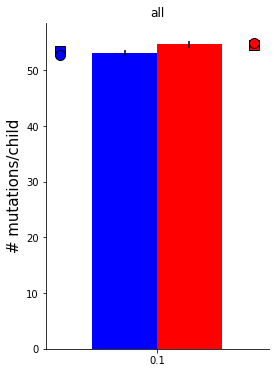

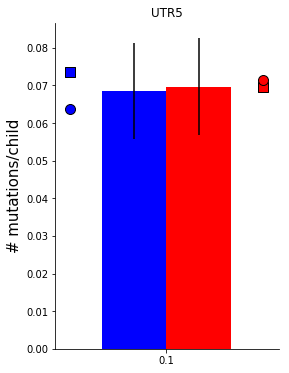

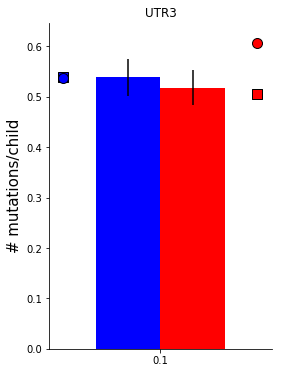

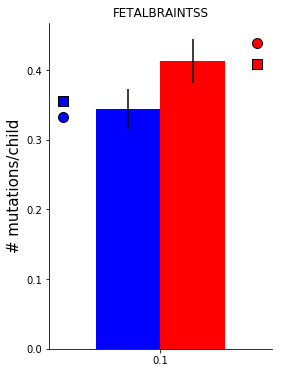

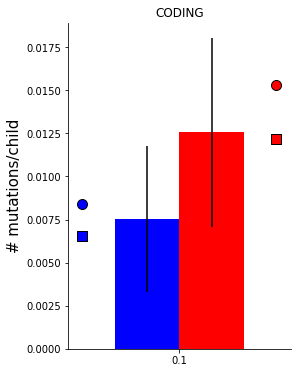

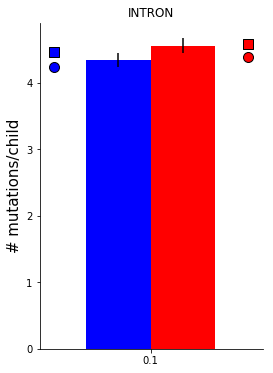

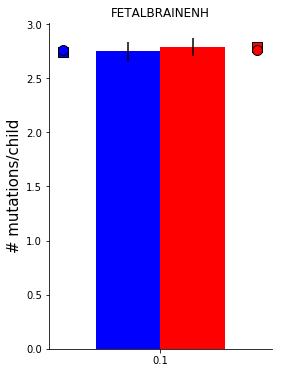

In [73]:
# Mutation count by category
fdata_list_annotations = [finaldata]
fdata_labels_list_annotations = ["all"]
for col in ['FEATURE-UTR5','FEATURE-UTR3', 'FEATURE-FETALBRAINTSS', 'FEATURE-CODING', 'FEATURE-INTRON', 'FEATURE-FETALBRAINENH']:
    fdata_list_annotations.append(finaldata[(finaldata[col]>0)])
    fdata_labels_list_annotations.append(col.split("-")[1])
PlotMutationCounts(finaldata, fdata_list_annotations, fdata_labels_list_annotations, figprefix="Figure3")

# Fig. 3B Odds ratios

In [81]:
def PlotOddsRatios(full_fdata, fdata_list, fdata_list_labels, figprefix="Figure3"):
    fdata = full_fdata
    
    # Get list of families to use
    families = set(fdata["family"])
    aff_female_families = set(fdata[(fdata["phenotype"]==2) & (fdata["sex"]=="female")]["family"])
    unaff_female_families = set(fdata[(fdata["phenotype"]==1) & (fdata["sex"]=="female")]["family"])
    aff_male_families = set(fdata[(fdata["phenotype"]==2) & (fdata["sex"]=="male")]["family"])
    unaff_male_families = set(fdata[(fdata["phenotype"]==1) & (fdata["sex"]=="male")]["family"])

    # Keep track of the percentage of mutations that are cases/ctrls for each category
    perc_mut_aff_all_list = []
    perc_mut_aff_female_list = []
    perc_mut_aff_male_list = []
    total_mut_all_list = []
    total_mut_female_list = []
    total_mut_male_list = []

    for i in range(len(fdata_list)):
        usedata = fdata_list[i]
        flabel = fdata_list_labels[i]
        
        # Get counts of unaff/aff mutations
        child_counts = usedata.groupby(["child","phenotype","family","sex"], as_index=False).agg({"posterior": len})
        child_counts.columns = ["child","phenotype","family","sex","nummut"]
        aff_counts = np.sum(child_counts[child_counts["phenotype"]==2]["nummut"])
        unaff_counts = np.sum(child_counts[child_counts["phenotype"]==1]["nummut"])
        aff_male_counts = np.sum(child_counts[(child_counts["phenotype"]==2)&
                                             (child_counts["sex"]=="male")]["nummut"])
        unaff_male_counts = np.sum(child_counts[(child_counts["phenotype"]==1)&
                                               (child_counts["sex"]=="male")]["nummut"])
        aff_female_counts = np.sum(child_counts[(child_counts["phenotype"]==2)&
                                             (child_counts["sex"]=="female")]["nummut"])
        unaff_female_counts = np.sum(child_counts[(child_counts["phenotype"]==1)&
                                               (child_counts["sex"]=="female")]["nummut"])
        # Update totals/percentages
        total_mut_all_list.append(np.sum(aff_counts)+np.sum(unaff_counts))
        perc_mut_aff_all_list.append(np.sum(aff_counts)/(np.sum(aff_counts)+np.sum(unaff_counts)))
        total_mut_female_list.append(np.sum(aff_female_counts)+np.sum(unaff_female_counts))
        perc_mut_aff_female_list.append(np.sum(aff_female_counts)/(np.sum(aff_female_counts)+np.sum(unaff_female_counts)))
        total_mut_male_list.append(np.sum(aff_male_counts)+np.sum(unaff_male_counts))
        perc_mut_aff_male_list.append(np.sum(aff_male_counts)/(np.sum(aff_male_counts)+np.sum(unaff_male_counts)))

    ########### Odds ratio plot ############
    # Need num_unnaf and num_aff for each category
    num_unaff = len(families)
    num_aff = len(families)
    num_unaff_female = len(unaff_female_families)
    num_aff_female = len(aff_female_families)
    num_unaff_male = len(unaff_male_families)
    num_aff_male = len(aff_male_families)
    
    # Compute odds ratios - n_u/n_a * (p/1-p), where p=% mutations in affecteds
    OR_all = num_unaff*1.0/num_aff*np.array([item/(1-item) for item in perc_mut_aff_all_list])
    OR_male = num_unaff_male*1.0/num_aff_male*np.array([item/(1-item) for item in perc_mut_aff_male_list])
    OR_female = num_unaff_female*1.0/num_aff_female*np.array([item/(1-item) for item in perc_mut_aff_female_list])

    # Compute stderrs on p total_mut_all_list, perc_mut_aff_all_list
    perc_se_all = [np.sqrt(perc_mut_aff_all_list[i]*(1-perc_mut_aff_all_list[i])/total_mut_all_list[i]) for \
                 i in range(len(perc_mut_aff_all_list))]
    perc_low_mut_aff_all_list = [perc_mut_aff_all_list[i]-perc_se_all[i]*1.96 for i in range(len(perc_se_all))]
    perc_high_mut_aff_all_list = [perc_mut_aff_all_list[i]+perc_se_all[i]*1.96 for i in range(len(perc_se_all))]
    OR_low_all = num_unaff*1.0/num_aff*np.array([item/(1-item) for item in perc_low_mut_aff_all_list])
    OR_high_all = num_unaff*1.0/num_aff*np.array([item/(1-item) for item in perc_high_mut_aff_all_list])

    # Male
    perc_se_male = [np.sqrt(perc_mut_aff_male_list[i]*(1-perc_mut_aff_male_list[i])/total_mut_male_list[i]) for \
                 i in range(len(perc_mut_aff_male_list))]
    perc_low_mut_aff_male_list = [perc_mut_aff_male_list[i]-perc_se_male[i]*1.96 for i in range(len(perc_se_male))]
    perc_high_mut_aff_male_list = [perc_mut_aff_male_list[i]+perc_se_male[i]*1.96 for i in range(len(perc_se_male))]
    OR_low_male = num_unaff_male*1.0/num_aff_male*np.array([item/(1-item) for item in perc_low_mut_aff_male_list])
    OR_high_male = num_unaff_male*1.0/num_aff_male*np.array([item/(1-item) for item in perc_high_mut_aff_male_list])
    # Female
    perc_se_female = [np.sqrt(perc_mut_aff_female_list[i]*(1-perc_mut_aff_female_list[i])/total_mut_female_list[i]) for \
                 i in range(len(perc_mut_aff_female_list))]
    perc_low_mut_aff_female_list = [perc_mut_aff_female_list[i]-perc_se_female[i]*1.96 for i in range(len(perc_se_female))]
    perc_high_mut_aff_female_list = [perc_mut_aff_female_list[i]+perc_se_female[i]*1.96 for i in range(len(perc_se_female))]
    OR_low_female = num_unaff_female*1.0/num_aff_female*np.array([item/(1-item) for item in perc_low_mut_aff_female_list])
    OR_high_female = num_unaff_female*1.0/num_aff_female*np.array([item/(1-item) for item in perc_high_mut_aff_female_list])

    for i in range(len(fdata_list)):
        print("##### %s #####"%(fdata_list_labels[i]))
        print("OR - all: %.2f (%.2f-%.2f)"%((OR_all[i]), (OR_low_all[i]), (OR_high_all[i])))
        print("OR - male: %.2f (%.2f-%.2f)"%((OR_male[i]), (OR_low_male[i]), (OR_high_male[i])))
        print("OR - female: %.2f (%.2f-%.2f)"%((OR_female[i]), (OR_low_female[i]), (OR_high_female[i])))

PlotOddsRatios(finaldata, fdata_list_annotations, fdata_labels_list_annotations, figprefix="Figure3")

##### all #####
OR - all: 1.03 (1.02-1.04)
OR - male: 1.02 (1.01-1.03)
OR - female: 1.04 (1.02-1.06)
##### UTR5 #####
OR - all: 1.02 (0.78-1.33)
OR - male: 0.94 (0.69-1.34)
OR - female: 1.12 (0.53-1.87)
##### UTR3 #####
OR - all: 0.96 (0.87-1.06)
OR - male: 0.94 (0.83-1.06)
OR - female: 1.13 (0.91-1.37)
##### FETALBRAINTSS #####
OR - all: 1.20 (1.07-1.35)
OR - male: 1.15 (1.00-1.34)
OR - female: 1.32 (1.02-1.65)
##### CODING #####
OR - all: 1.67 (0.84-3.82)
OR - male: 1.85 (0.81-9.91)
OR - female: 1.82 (0.07-5.95)
##### INTRON #####
OR - all: 1.05 (1.02-1.08)
OR - male: 1.03 (0.99-1.07)
OR - female: 1.04 (0.96-1.11)
##### FETALBRAINENH #####
OR - all: 1.01 (0.97-1.06)
OR - male: 1.02 (0.97-1.07)
OR - female: 1.00 (0.91-1.10)


# Fig.  3C Mutation size

###### all ######
MannwhitneyuResult(statistic=3659432165.0, pvalue=0.017489510058466225)
Unaff n=84515 mean=2.434206945512631
Aff n=87063 mean=2.465031069455452
###### UTR5 ######
MannwhitneyuResult(statistic=6213.5, pvalue=0.6531485293637433)
Unaff n=109 mean=1.798165137614679
Aff n=111 mean=1.8288288288288288
###### UTR3 ######
MannwhitneyuResult(statistic=357073.0, pvalue=0.6365612235360728)
Unaff n=858 mean=2.2762237762237763
Aff n=825 mean=2.4375757575757575
###### FETALBRAINTSS ######
MannwhitneyuResult(statistic=167012.5, pvalue=0.008134303155412448)
Unaff n=548 mean=2.0364963503649633
Aff n=658 mean=2.3677811550151975
###### CODING ######
MannwhitneyuResult(statistic=120.5, pvalue=0.5174439440836233)
Unaff n=12 mean=2.0
Aff n=20 mean=1.65
###### INTRON ######
MannwhitneyuResult(statistic=25059800.5, pvalue=0.49437898607216696)
Unaff n=6912 mean=2.4500868055555554
Aff n=7252 mean=2.433949255377827
###### FETALBRAINENH ######
MannwhitneyuResult(statistic=9527030.0, pvalue=0.0361

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


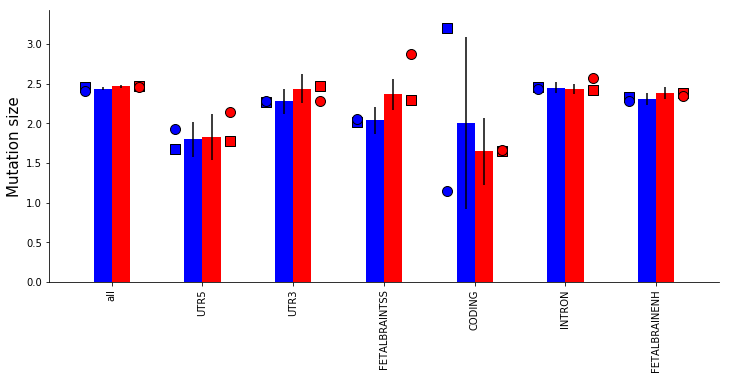

In [64]:
# Mutation size by category
PlotMutationSize(fdata_list_annotations, fdata_labels_list_annotations, figprefix="Figure3")